In [2]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algrebra
import numpy as np


# Technical indicators
from scipy.signal import savgol_filter, convolve, lfilter
from ta.trend import ema_indicator, trix, dpo

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope


from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 30, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend

In [3]:
SYMBOL= 'BTC'
df = loadFromDB(f'./data/15m/{SYMBOL}-USDT.csv')
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(93762, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA20
Date,,,,,,,
2020-01-01 05:45:00,7221.84,7228.90,7216.18,7217.27,66.899266,1577853900,7214.263134
2020-01-01 06:00:00,7217.26,7229.76,7217.26,7223.95,98.086889,1577854800,7215.185693
2020-01-01 06:15:00,7223.14,7223.67,7216.65,7220.18,78.930659,1577855700,7215.661341
2020-01-01 06:30:00,7220.17,7224.14,7218.05,7220.60,83.405918,1577856600,7216.131689
2020-01-01 06:45:00,7220.31,7228.16,7219.54,7224.21,84.247130,1577857500,7216.901052


In [3]:
from tsmoothie.regression_basis import cubic_spline
from tsmoothie.smoother import ConvolutionSmoother, LowessSmoother, KalmanSmoother, PolynomialSmoother, ExponentialSmoother, WindowWrapper

# operate smoothing
#smoother = LowessSmoother(smooth_fraction=0.01, iterations=2)
#smoother = ConvolutionSmoother(50,'bartlett')
#smoother = ExponentialSmoother(1, 0.3)
#
#smoother.smooth(df.EMA20.values.reshape(1, -1))
 
df['EMA20_denoised'] =savgol_filter(df.EMA20.values, 25, 2, mode='nearest')#filterData(df.EMA20.values,'hpf')#
df['EMA20_diff'] = df.EMA20_denoised.diff(1)#.diff(1)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised,EMA20_diff
Date,,,,,,,,,
2020-01-01 06:00:00,7217.26,7229.76,7217.26,7223.95,98.086889,1577854800,7215.185693,7216.110069,0.682806
2020-01-01 06:15:00,7223.14,7223.67,7216.65,7220.18,78.930659,1577855700,7215.661341,7216.877651,0.767582
2020-01-01 06:30:00,7220.17,7224.14,7218.05,7220.60,83.405918,1577856600,7216.131689,7217.675409,0.797758
2020-01-01 06:45:00,7220.31,7228.16,7219.54,7224.21,84.247130,1577857500,7216.901052,7218.356506,0.681096
2020-01-01 07:00:00,7224.24,7231.68,7222.87,7229.31,106.983123,1577858400,7218.082857,7218.929018,0.572512
...,...,...,...,...,...,...,...,...,...
2022-09-05 11:00:00,19781.65,19804.50,19750.01,19752.00,2253.029480,1662368400,19778.641881,19777.087698,-1.696449
2022-09-05 11:15:00,19752.00,19771.22,19729.00,19748.51,1720.607330,1662369300,19775.772178,19775.725978,-1.361720
2022-09-05 11:30:00,19749.24,19779.93,19733.26,19765.90,1500.137580,1662370200,19774.831971,19774.669997,-1.055981


In [43]:
X = df.EMA20.iloc[:-1].values
y = df.EMA20.iloc[1:].values
X,y

(array([2.17295727, 2.1726661 , 2.172336  , ..., 4.26023615, 4.2670327 ,
        4.27400102]),
 array([2.1726661 , 2.172336  , 2.17678019, ..., 4.2670327 , 4.27400102,
        4.28389616]))

In [49]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X.reshape(-1, 1),y)
lr.score(X.reshape(-1, 1),y)

0.9999392936727756

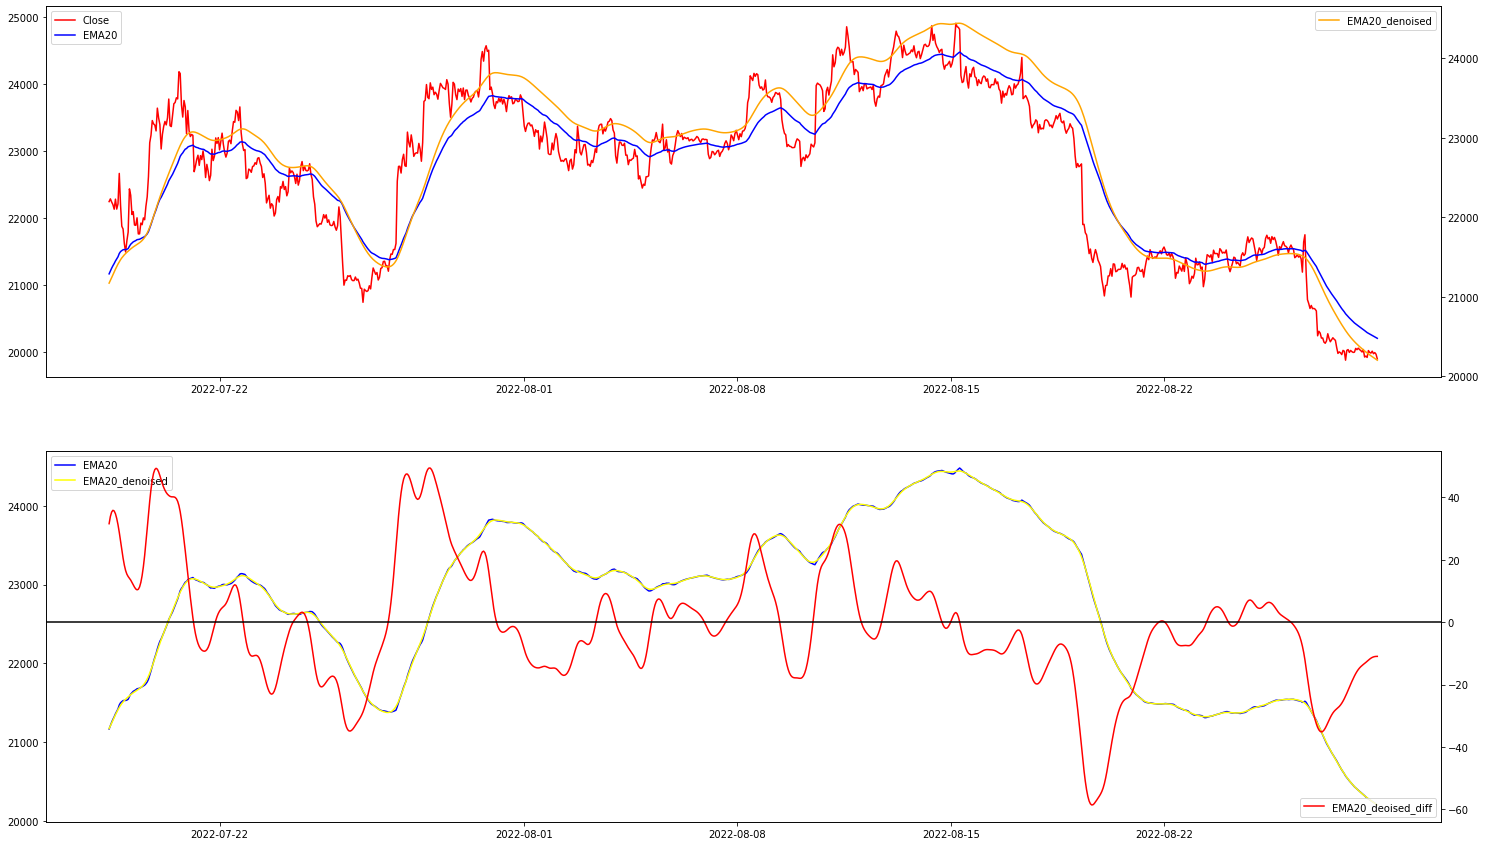

In [4]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ind=1000

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-ind:], color='red',label='Close')
ax_left[0].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_right[0].plot(df.EMA20_denoised[-ind:], color='orange',label='EMA20_denoised')
ax_left[0].legend(loc="upper left")
#ax_right[0].plot(df.EMA20_diff[-ind:], color='orange',label='EMA20_deoised_diff')
#ax_right[0].axhline(y=0, color='black')
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_left[1].plot(df.EMA20_denoised[-ind:], color='yellow',label='EMA20_denoised')
ax_right[1].plot(df.EMA20_diff[-ind:], color='red',label='EMA20_deoised_diff')
ax_right[1].axhline(y=0, color='black')
ax_left[1].legend(loc="upper left")
ax_right[1].legend(loc="lower right")
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

Period : [2020-01-01 06:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 451934482028.1 $
Performance vs US Dollar : 45193448102.81 %
Buy and Hold Performence : 173.52 %
Performance vs Buy and Hold : 26044882623.1 %
Best trade : +19.45 %, the 2020-12-17 19:30:00
Worst trade : -2.98 %, the 2021-01-11 12:00:00
Worst drawBack : -5.0 %
Total fees :  86913693228.74 $

----- Trades Informations -----
Total trades on period : 1951
Number of positive trades : 1494
Number of negative trades :  457
Trades win rate ratio : 76.58 %
Average trades performance : 1.12 %
Average positive trades : 1.55 %
Average negative trades : -0.31 %

----- Plot -----


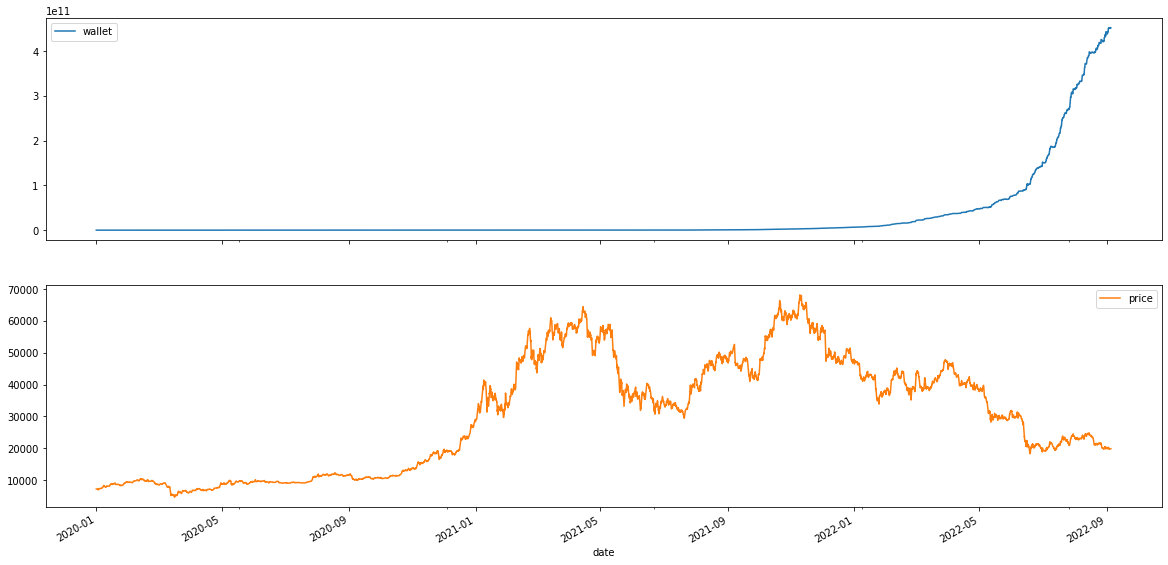

In [4]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# New calculation (inloop filtering)

In [19]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
df['EMA20_denoised'] =filterData(df.EMA20.values,'hpf')
#savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)
print(df.shape)
df.head()

(21784, 9)


,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised,EMA20_diff
Date,,,,,,,,,
2020-01-01 20:00:00,7240.1,7240.1,7224.9,7229.0,13.119735,1577905200,7217.651537,7224.161809,NaN
2020-01-01 21:00:00,7229.0,7240.0,7227.0,7236.9,15.305158,1577908800,7219.484724,7221.964799,-2.197010
2020-01-01 22:00:00,7236.8,7239.4,7226.6,7234.2,16.852126,1577912400,7220.886179,7219.713536,-2.251262
2020-01-01 23:00:00,7234.1,7234.1,7190.0,7198.0,38.299173,1577916000,7218.706543,7217.333102,-2.380434
2020-01-02 00:00:00,7198.0,7202.3,7180.0,7200.2,18.005546,1577919600,7216.944015,7214.758349,-2.574753


Period : [2020-01-01 20:00:00] -> [2022-08-29 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 121629210.99 $
Performance vs US Dollar : 12162821.1 %
Buy and Hold Performence : 175.21 %
Performance vs Buy and Hold : 6941660.58 %
Best trade : +29.49 %, the 2020-04-30 15:00:00
Worst trade : -4.78 %, the 2021-01-12 14:00:00
Worst drawBack : -5.0 %
Total fees :  6133915.67 $

----- Trades Informations -----
Total trades on period : 367
Number of positive trades : 313
Number of negative trades :  54
Trades win rate ratio : 85.29 %
Average trades performance : 3.42 %
Average positive trades : 4.1 %
Average negative trades : -0.55 %

----- Plot -----


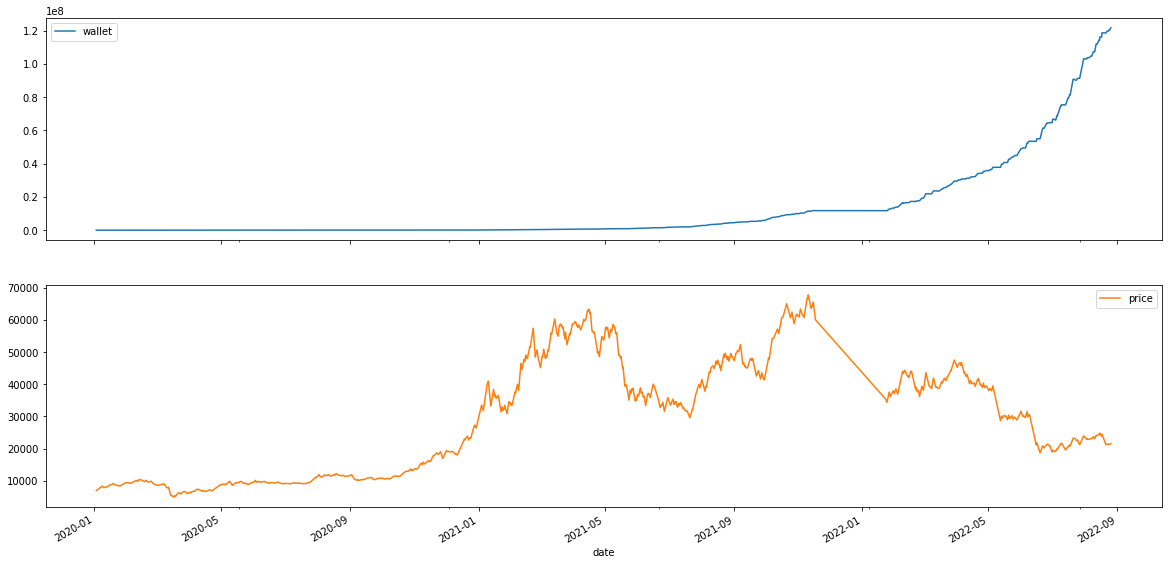

In [12]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df.iloc[1000:],buyCondition,sellCondition,equity=1000)

In [ ]:

df.drop(columns=['EMA20_denoised','EMA20_diff'],inplace=True)

In [32]:
df_final = pd.DataFrame()
for col in df.columns:
    df_final[col]=np.nan

df_final['EMA20_denoised_lowess'] = np.nan
df_final['EMA20_denoised_lowess_diff'] = np.nan
df_final['EMA20_denoised_conv']  = np.nan
df_final['EMA20_denoised_conv_diff'] = np.nan
df_final['EMA20_denoised_hpf']  = np.nan
df_final['EMA20_denoised_hpf_diff']  = np.nan
df_final['EMA20_denoised_savgol']  = np.nan
df_final['EMA20_denoised_savgol_diff'] = np.nan
df_final

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised_lowess,EMA20_denoised_lowess_diff,EMA20_denoised_conv,EMA20_denoised_conv_diff,EMA20_denoised_hpf,EMA20_denoised_hpf_diff,EMA20_denoised_savgol,EMA20_denoised_savgol_diff


In [ ]:
kucoin_range = 1000
from multiprocessing import Pool, cpu_count

# task to execute in another process
def task():
    df_i = df.iloc[i:i+kucoin_range]
    df_i.dropna(inplace=True)
    df_i['EMA20_denoised_lowess'] = LowessSmoother(smooth_fraction=0.01, iterations=2).smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_lowess_diff'] = df_i.EMA20_denoised_lowess.diff(1)
    df_i['EMA20_denoised_conv'] = ConvolutionSmoother(50,'bartlett').smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_conv_diff'] = df_i.EMA20_denoised_conv.diff(1)
    df_i['EMA20_denoised_hpf'] = filterData(df_i.EMA20.values,'savgol')
    df_i['EMA20_denoised_hpf_diff'] = df_i.EMA20_denoised_hpf.diff(1)
    df_i['EMA20_denoised_savgol'] = filterData(df_i.EMA20.values,'hpf')
    df_i['EMA20_denoised_savgol_diff'] = df_i.EMA20_denoised_savgol.diff(1)
    return df_i.iloc[-1]
    #df_final = df_final.append(df_i.iloc[-1],ignore_index=True)


with Pool(cpu_count()) as pool:
    for result in pool.map(task,range(len(df)-kucoin_range)):
        df_final = df_final.append(result,ignore_index=True)
        print(f'{len(df_final)} records')


In [26]:
from tsmoothie.regression_basis import cubic_spline
from tsmoothie.smoother import ConvolutionSmoother, LowessSmoother, KalmanSmoother, PolynomialSmoother, ExponentialSmoother, WindowWrapper


kucoin_range = 1000

print(f'Before inloop :')
print(df_final)

for i in range(len(df)-kucoin_range):
    df_i = df.iloc[i:i+kucoin_range]
    df_i.dropna(inplace=True)
    df_i['EMA20_denoised_lowess'] = LowessSmoother(smooth_fraction=0.01, iterations=2).smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_lowess_diff'] = df_i.EMA20_denoised_lowess.diff(1)
    df_i['EMA20_denoised_conv'] = ConvolutionSmoother(50,'bartlett').smooth(df_i.EMA20.values.reshape(1, -1)).smooth_data.reshape(-1,1)
    df_i['EMA20_denoised_conv_diff'] = df_i.EMA20_denoised_conv.diff(1)
    df_i['EMA20_denoised_hpf'] = filterData(df_i.EMA20.values,'savgol')
    df_i['EMA20_denoised_hpf_diff'] = df_i.EMA20_denoised_hpf.diff(1)
    df_i['EMA20_denoised_savgol'] = filterData(df_i.EMA20.values,'hpf')
    df_i['EMA20_denoised_savgol_diff'] = df_i.EMA20_denoised_savgol.diff(1)
    df_final = df_final.append(df_i.iloc[-1],ignore_index=True)
    print(f'{len(df_final)} records')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_lowess_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_lowess_diff<0 else False

print(f'Lowess : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_conv_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_conv_diff<0 else False

print(f'Conv : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_hpf_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_hpf_diff<0 else False

print(f'HPF : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_savgol_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_denoised_savgol_diff<0 else False

print(f'Savgol : {strategyTester(df,buyCondition,sellCondition,equity=1000, optimization_process=True)}')

Before inloop :
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised_lowess, EMA20_denoised_lowess_diff, EMA20_denoised_conv, EMA20_denoised_conv_diff, EMA20_denoised_hpf, EMA20_denoised_hpf_diff, EMA20_denoised_savgol, EMA20_denoised_savgol_diff]
Index: []
0 records
In loop
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Timestamp, EMA20, EMA20_denoised

KeyboardInterrupt: 